## Data Lagging

To address the data lagging issue in our analysis of the relationship between CO2 and the number of occupants, we need to consider the delay between people entering or exiting the room and the resulting change in CO2 levels. This delay occurs because it takes a certain amount of time for the CO2 levels to populate the room after individuals have entered or left.

To quantify this lag, we introduce the concept of the `upper bound value (UB)`. The UB represents the maximum CO2 value that can be reached in the room and is calculated based on the room volume. By determining the UB, we can estimate the time lag needed to account for the delay between occupancy changes and CO2 level changes.

The UB is calculated as follows:

$$UB = \left|\frac{RL \times RW \times RH}{C}\right|$$

where:  
- $UB$ : Upper Bound Value
- $RL$ : Room Length 
- $RW$ : Room Width
- $RH$ : Room Height
- $C$ : Constant (100)


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
# def calculate_upper_bound(rl, rw, rh, c=100):
#     ub = abs((rl * rw * rh) / c)
#     return ub

def calculate_upper_bound(rl, rw, rh, c=100):
    # use tensorflow
    rl = tf.constant(rl, dtype=tf.float32)
    rw = tf.constant(rw, dtype=tf.float32)
    rh = tf.constant(rh, dtype=tf.float32)
    c = tf.constant(c, dtype=tf.float32)
    
    ub = tf.abs((rl * rw * rh) / c)
    return ub

To calculate a line of best fit, we need to calculate the slope value between CO2 and occupancy data.  

$$SL = \frac{\sum(O_t - \bar{O_t})(C_t - \bar{C_t})}{\sum(O_t - \bar{O_t})^2}$$

where:
- $SL$ : Slope of the linear regression line
- $O_t$ : Occupancy value
- $\bar{O_t}$ : Sample means of the known occupancy value
- $C_t$ : CO2 value
- $\bar{C_t}$ : Sample means of the known CO2 value

In [3]:
def calculate_slope(occupancy_values, co2_values):

    occupancy_values = tf.constant(occupancy_values, dtype=tf.float32)
    co2_values = tf.constant(co2_values, dtype=tf.float32)
    
    # calculate the mean of occupancy values
    occupancy_mean = tf.reduce_mean(occupancy_values)
    co2_mean = tf.reduce_mean(co2_values)
    
    # calculate the numerator
    numerator = tf.reduce_sum(
        (occupancy_values - occupancy_mean) * (co2_values - co2_mean))
    
    # calculate the denominator
    denominator = tf.reduce_sum(
        (occupancy_values - occupancy_mean) ** 2)
    
    # calculate the slope
    slope = numerator / denominator
    
    return slope

Let's now calculate the intercept value of the linear regression line.

$$IC = \bar{C_t} - SL \times \bar{O_t}$$

where:
- $IC$ : Intercept of the linear regression line
- $\bar{C_t}$ : Sample means of the known CO2 value
- $SL$ : Slope of the linear regression line
- $\bar{O_t}$ : Sample means of the known occupancy value


In [4]:
def calculate_intecept_value(occupancy_values, co2_values, slope):
    
    occupancy_values = tf.constant(occupancy_values, dtype=tf.float32)
    co2_values = tf.constant(co2_values, dtype=tf.float32)
    
    # calculate the mean of occupancy values
    occupancy_mean = tf.reduce_mean(occupancy_values)
    co2_mean = tf.reduce_mean(co2_values)
    
    # calculate the intercept
    intercept = co2_mean - (slope * occupancy_mean)
    
    return intercept

Finally, the formula for the line of best fit is:

$$LBF = (O_t - (SL \times C_t + IC))^2$$

where:
- $LBF$ : Line of best fit
- $O_t$ : Occupancy value
- $SL$ : Slope of the linear regression line
- $C_t$ : CO2 value
- $IC$ : Intercept of the linear regression line


In [5]:
def calculate_line_of_best_fit(occupancy_value, co2_value, slope, intercept):
    
    occupancy_value = tf.constant(occupancy_value, dtype=tf.float32)
    co2_value = tf.constant(co2_value, dtype=tf.float32)
    
    # calculate the line of best fit
    line_of_best_fit = (occupancy_value - (slope * co2_value + intercept)) ** 2
    
    return line_of_best_fit

<!-- write in red to indicate that this place needs to be completed -->
# TODO:
- complete the data lagging section after answers from Irvan

## Seasonal-Trend Decomposition

STD is a method to decompose a time series into three components: trend, seasonal, and residual.  
`The trend component` $\textcolor{orange}{(T_t)}$ is the long-term progression of the series.  
`The seasonal component` $\textcolor{orange}{(S_t)}$ is the repeating short-term cycle in the series.  
`The cyclical component` $\textcolor{orange}{(C_t)}$ is the repeating up and down movements in the series that are not of a fixed period.  
`The residual component` $\textcolor{orange}{(e_t)}$ is the random variation in the series, and is calculated as the difference between the original series and the sum of the trend, seasonal, and cyclical components.

In the paper we're implementing, the cyclical component is combined with the trend component to make a simpler model.

The formula for the STD is:

In [6]:
def decompose_time_series(df):
    # Step 1: Calculate 2 × 12 moving average in the raw data
    trend_co2 = df['co2'].rolling(window=12, center=True).mean()
    trend_occupancy = df['peoplecount_rgb'].rolling(window=12, center=True).mean()

    # Step 2: Calculate centred ratios
    centred_ratios_co2 = df['co2'] / trend_co2
    centred_ratios_occupancy = df['peoplecount_rgb'] / trend_occupancy

    for _ in range(2):
        # Step 3: Calculate rough seasonal feature
        seasonal_co2 = centred_ratios_co2.rolling(window=2).mean().rolling(window=2).mean()
        seasonal_occupancy = centred_ratios_occupancy.rolling(window=2).mean().rolling(window=2).mean()

        # Step 4: Calculate irregular feature
        et_co2 = centred_ratios_co2 / seasonal_co2
        et_occupancy = centred_ratios_occupancy / seasonal_occupancy

        # Step 5: Modify irregular feature by multiplying with seasonal feature
        modified_et_co2 = et_co2 * seasonal_co2
        modified_et_occupancy = et_occupancy * seasonal_occupancy

        # Step 6: Update seasonal feature
        seasonal_co2 = modified_et_co2.rolling(window=2).mean().rolling(window=2).mean()
        seasonal_occupancy = modified_et_occupancy.rolling(window=2).mean().rolling(window=2).mean()

        # Step 7: Calculate preliminary seasonal adjusted series
        preliminary_seasonal_adjusted_co2 = df['co2'] / seasonal_co2
        preliminary_seasonal_adjusted_occupancy = df['peoplecount_rgb'] / seasonal_occupancy

        # Step 8: Estimate trend feature using weighted Henderson moving average
        trend_co2 = preliminary_seasonal_adjusted_co2.rolling(window=12, center=True).mean()
        trend_occupancy = preliminary_seasonal_adjusted_occupancy.rolling(window=12, center=True).mean()

        # Step 9: Calculate new centred ratios
        centred_ratios_co2 = df['co2'] / trend_co2
        centred_ratios_occupancy = df['peoplecount_rgb'] / trend_occupancy

        for _ in range(2):
            # Step 10: Calculate rough seasonal feature using 3 × 5 moving average
            seasonal_co2 = centred_ratios_co2.rolling(window=3, center=True).mean().rolling(window=5, center=True).mean()
            seasonal_occupancy = centred_ratios_occupancy.rolling(window=3, center=True).mean().rolling(window=5, center=True).mean()

            # Step 11: Update irregular feature using modified centred ratios and 3 × 5 moving average
            et_co2 = centred_ratios_co2 / seasonal_co2
            et_occupancy = centred_ratios_occupancy / seasonal_occupancy

            modified_et_co2 = et_co2 * seasonal_co2
            modified_et_occupancy = et_occupancy * seasonal_occupancy

            # Step 12: Update seasonal feature using 3 × 5 moving average
            seasonal_co2 = modified_et_co2.rolling(window=3, center=True).mean().rolling(window=5, center=True).mean()
            seasonal_occupancy = modified_et_occupancy.rolling(window=3, center=True).mean().rolling(window=5, center=True).mean()

            # Step 13: Calculate reminder feature
            reminder_feature_co2 = preliminary_seasonal_adjusted_co2 / trend_co2
            reminder_feature_occupancy = preliminary_seasonal_adjusted_occupancy / trend_occupancy

    return trend_co2, trend_occupancy, seasonal_co2, seasonal_occupancy, reminder_feature_co2, reminder_feature_occupancy 

Finally, the formula for the seasonal-trend decomposition is:

$$STD_t = T_t + S_t + e_t$$

We used what we call *additive model*, which means that the components are added together.

For CO2 :  
$$C_t = T_t^C + S_t^C + e_t^C$$  
For People Count :  
$$O_t = T_t^O + S_t^O + e_t^O$$

To predict the people count at time $t+1$ up to $t+n$, we need to predict the trend, seasonal and residual components at time $t+1$ up to $t+n$ first, then add them together to reconstruct the original time series.




### Testing the STD

Let's test the STD on the data we have.  
 
First, we start by calculating the upper bound value (UB) for the room, then we calculate the slope and intercept values for the line of best fit.

In [7]:
# test the functions
import pandas as pd

# read the data
df = pd.read_csv('../data/final_df.csv')
# calculate upper bound
ub = calculate_upper_bound(3.5, 2.5, 2.5)
print('The upper bound is: ', ub.numpy())
    
# calculate slope
slope = calculate_slope(df['peoplecount_rgb'], df['co2'])
print('The slope is: ', slope.numpy())

The upper bound is:  0.21875
The slope is:  16.150505


In [8]:
# calculate intercept
intercept = calculate_intecept_value(df['peoplecount_rgb'], df['co2'], slope)
print('The intercept is: ', intercept.numpy())

The intercept is:  443.61987


In [9]:
# calculate line of best fit
line_of_best_fit = calculate_line_of_best_fit(df['peoplecount_rgb'], df['co2'], slope, intercept)
print('The line of best fit is: ', line_of_best_fit.numpy())

The line of best fit is:  [56513424. 55546308. 60465388. ... 51993928. 52695008. 52695008.]


We then proceed to calculate the trend, seasonal, and residual components for the CO2 and people count data.

Finally, we reconstruct the original time series by adding the trend, seasonal, and residual components together.

In [10]:
# decompose time series
trend_co2, trend_occupancy, seasonal_co2, seasonal_occupancy, reminder_feature_co2, reminder_feature_occupancy = decompose_time_series(df)

We can check the components by plotting them.

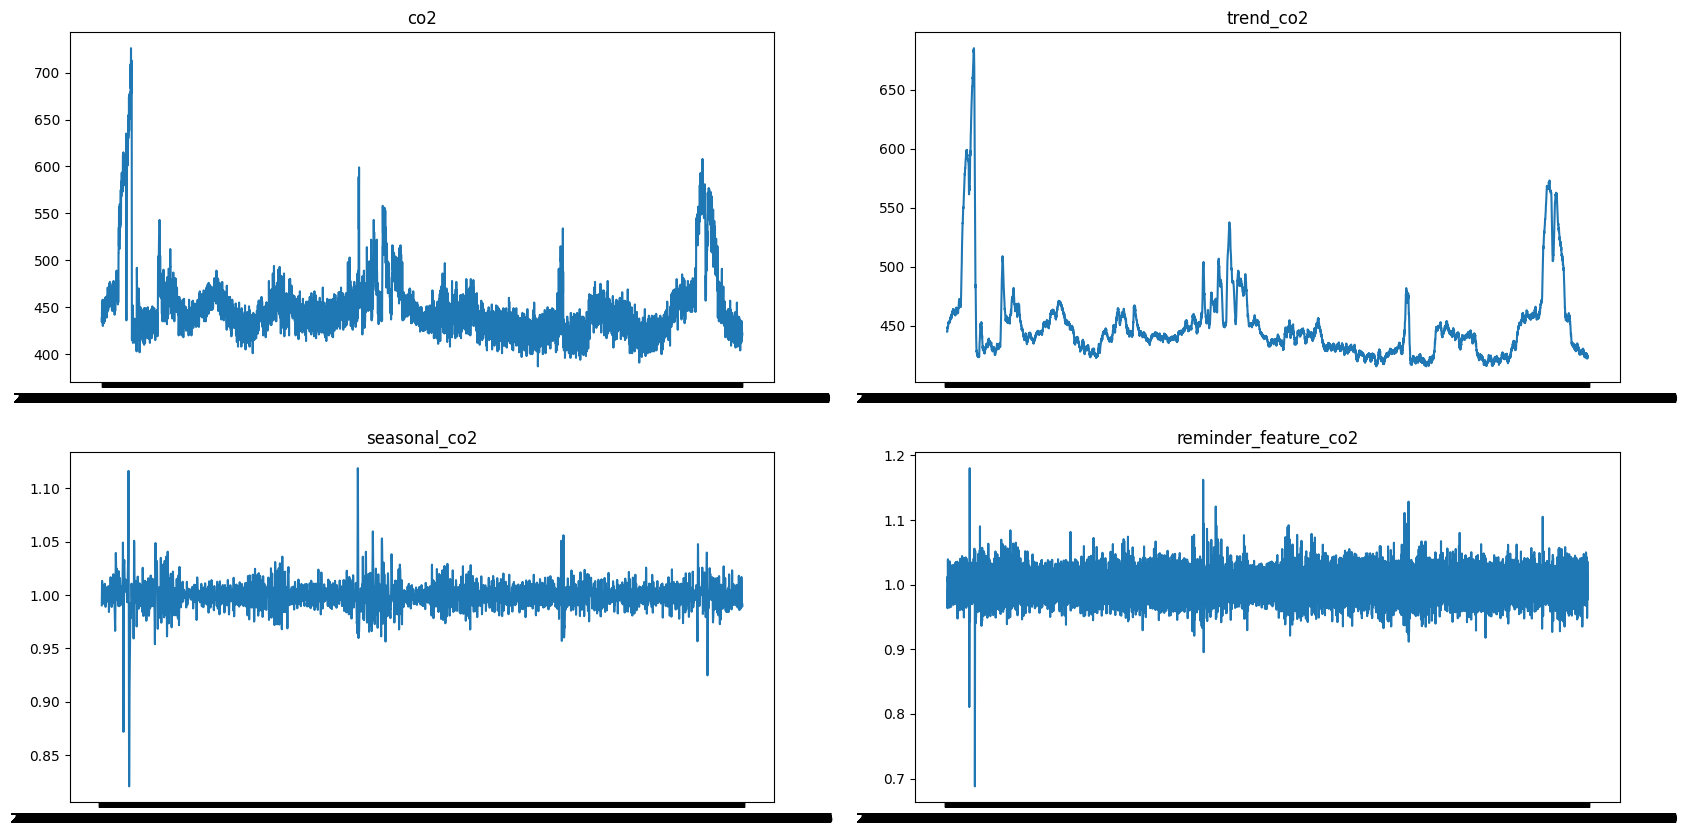

In [11]:
x = df['time']

import matplotlib.pyplot as plt
figure, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0, 0].plot(x, df['co2'], label='co2')
axes[0, 0].set_title('co2')

axes[0, 1].plot(x, trend_co2, label='trend_co2')
axes[0, 1].set_title('trend_co2')

axes[1, 0].plot(x, seasonal_co2, label='seasonal_co2')
axes[1, 0].set_title('seasonal_co2')

axes[1, 1].plot(x, reminder_feature_co2, label='reminder_feature_co2')
axes[1, 1].set_title('reminder_feature_co2')

plt.show()

In [12]:
# replace all the nan values with 0
trend_occupancy = trend_occupancy.fillna(0)
seasonal_occupancy = seasonal_occupancy.fillna(0) 
reminder_feature_occupancy = reminder_feature_occupancy.fillna(0)

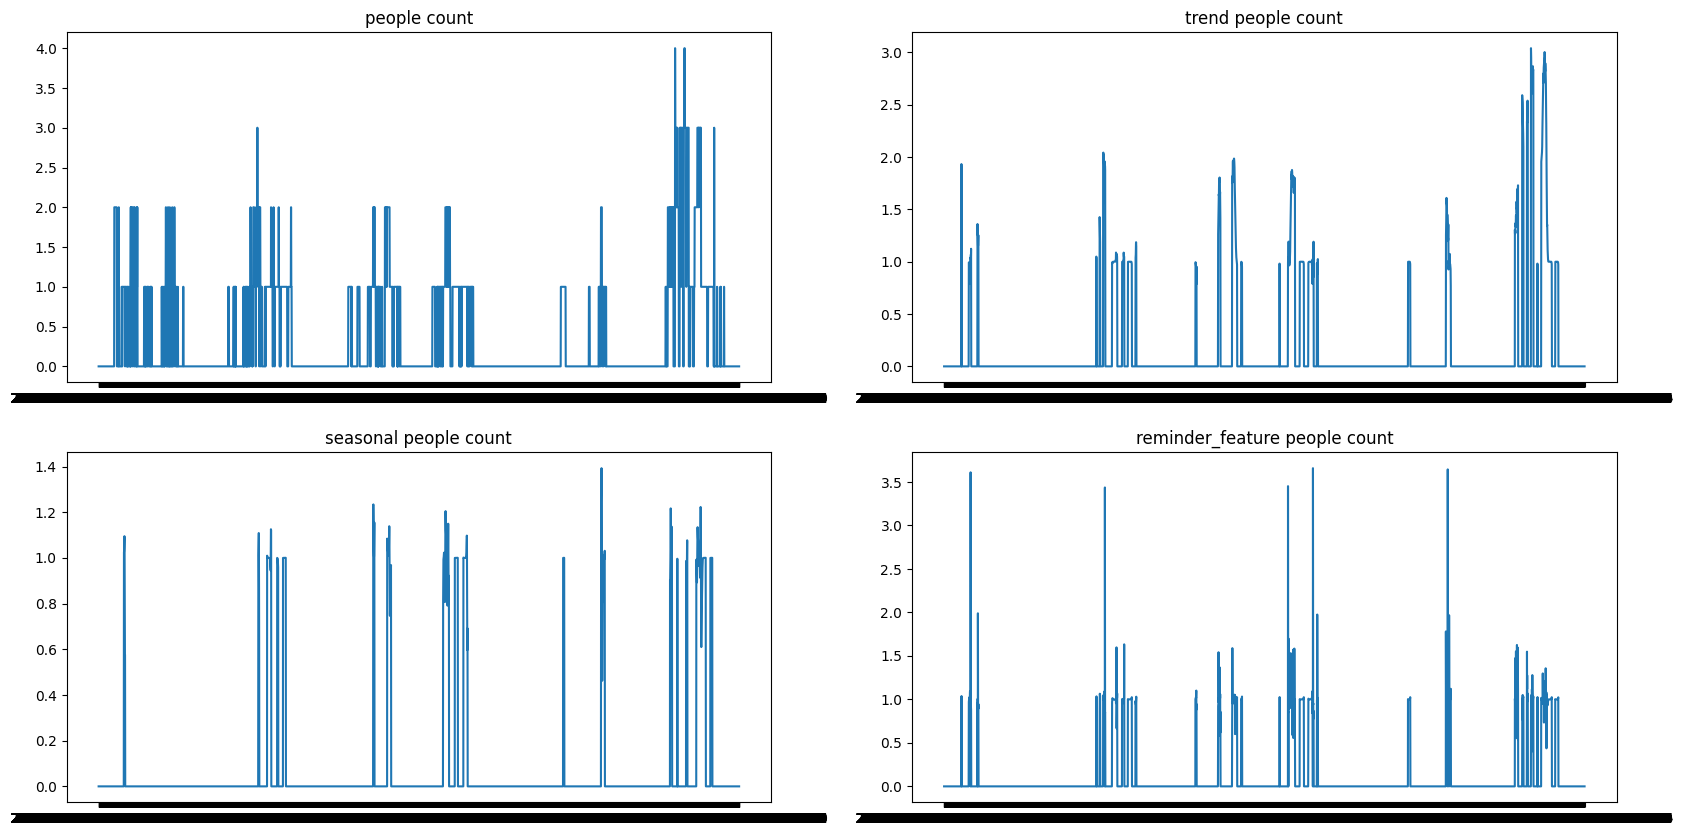

In [13]:
figure, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0, 0].plot(x, df['peoplecount_rgb'], label='people count')
axes[0, 0].set_title('people count')

axes[0, 1].plot(x, trend_occupancy, label='trend people count')
axes[0, 1].set_title('trend people count')

axes[1, 0].plot(x, seasonal_occupancy, label='seasonal people count')
axes[1, 0].set_title('seasonal people count')

axes[1, 1].plot(x, reminder_feature_occupancy, label='reminder_feature people count')
axes[1, 1].set_title('reminder_feature people count')

plt.show()

## Correlation Models

In [16]:
def pearson_product_moment_correlation_coefficient(occupancy_values, co2_values, n):
    # numerator
    numerator = n * tf.reduce_sum(
        occupancy_values * co2_values) - tf.reduce_sum(
            occupancy_values) * tf.reduce_sum(co2_values)
        
    # denominator
    denominator = tf.sqrt(
        tf.abs((n * tf.reduce_sum(occupancy_values ** 2) - tf.reduce_sum(occupancy_values) ** 2)) * 
        tf.abs((n * tf.reduce_sum(co2_values ** 2) - tf.reduce_sum(co2_values) ** 2)))
    
    return numerator / denominator

In [18]:
# test the function
import numpy as np

# test on the actual data
occupancy_values = tf.constant(df['peoplecount_rgb'], dtype=tf.float32) 
co2_values = tf.constant(df['co2'], dtype=tf.float32)
n = tf.constant(len(df['peoplecount_rgb']), dtype=tf.float32)

# calculate the pearson product moment correlation coefficient
print('Correlation coefficient Pearson’s r value is ',pearson_product_moment_correlation_coefficient(occupancy_values, co2_values, n).numpy())

Correlation coefficient Pearson’s r value is  0.29420567
